In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Configuration and Parameters

In [25]:
# Configuration

import os

class Config:
    # Paths - Use absolute paths to avoid confusion
    # Get the notebook's directory and go up one level to project root
    NOTEBOOK_DIR = Path(os.getcwd())
    if NOTEBOOK_DIR.name == 'notebooks':
        DATA_DIR = NOTEBOOK_DIR.parent
    else:
        # If running from project root
        DATA_DIR = NOTEBOOK_DIR
    
    # All data (CSV files and subset folders) are in data/raw/ directory
    RAW_DATA_DIR = DATA_DIR / 'data' / 'raw'
    ANNOTATIONS_FILE = RAW_DATA_DIR / 'annotations.csv'
    CANDIDATES_FILE = RAW_DATA_DIR / 'candidates_V2.csv'

    # Patch extraction parameters
    PATCH_SIZE = 64  # 64x64x64 patches
    
    # Class balancing
    POSITIVE_NEGATIVE_RATIO = 1 / 3  # 1:3 ratio
    OVERSAMPLE_POSITIVE = 2  # Oversample positive samples 2x
    
    # Training parameters
    BATCH_SIZE = 4  # Small batch size for 3D patches
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-5
    
    # Data split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # HU normalization
    HU_MIN = -1000
    HU_MAX = 400
    
    # Model save path
    MODEL_SAVE_DIR = DATA_DIR / 'models' / 'models_3d_cnn'
    
config = Config()
config.MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Current working directory: {os.getcwd()}")
print(f"Notebook directory: {config.NOTEBOOK_DIR}")
print(f"Data directory (project root): {config.DATA_DIR.resolve()}")
print(f"Raw data directory: {config.RAW_DATA_DIR.resolve()}")
print(f"\nPatch size: {config.PATCH_SIZE}x{config.PATCH_SIZE}x{config.PATCH_SIZE}")
print(f"Positive:Negative ratio: 1:{int(1/config.POSITIVE_NEGATIVE_RATIO)}")
print(f"Batch size: {config.BATCH_SIZE}")

# Check if files exist
print(f"\n{'='*80}")
print("FILE CHECKS:")
print(f"{'='*80}")
print(f"Annotations file: {config.ANNOTATIONS_FILE.resolve()}")
print(f"  -> Exists: {config.ANNOTATIONS_FILE.exists()}")
print(f"Candidates file: {config.CANDIDATES_FILE.resolve()}")
print(f"  -> Exists: {config.CANDIDATES_FILE.exists()}")

# Check for subset folders (in data/raw/)
subset_check = list(config.RAW_DATA_DIR.glob('subset*'))
print(f"\nSubset folders in {config.RAW_DATA_DIR}:")
print(f"  -> Found {len(subset_check)} subset folders")
if len(subset_check) > 0:
    for sf in subset_check[:3]:  # Show first 3
        print(f"     - {sf.name}")
print(f"{'='*80}")

Current working directory: e:\Kanav\Projects\CAD_C\notebooks
Notebook directory: e:\Kanav\Projects\CAD_C\notebooks
Data directory (project root): E:\Kanav\Projects\CAD_C
Raw data directory: E:\Kanav\Projects\CAD_C\data\raw

Patch size: 64x64x64
Positive:Negative ratio: 1:3
Batch size: 4

FILE CHECKS:
Annotations file: E:\Kanav\Projects\CAD_C\data\raw\annotations.csv
  -> Exists: True
Candidates file: E:\Kanav\Projects\CAD_C\data\raw\candidates_V2.csv
  -> Exists: True

Subset folders in e:\Kanav\Projects\CAD_C\data\raw:
  -> Found 10 subset folders
     - subset0
     - subset1
     - subset2


## 2. Load and Explore Annotations

In [26]:
# Load annotations and candidates
annotations_df = pd.read_csv(config.ANNOTATIONS_FILE)
candidates_df = pd.read_csv(config.CANDIDATES_FILE)

print("Annotations shape:", annotations_df.shape)
print("\nAnnotations columns:", annotations_df.columns.tolist())
print("\nFirst few annotations:")
print(annotations_df.head())

print("\n" + "="*80)
print("\nCandidates shape:", candidates_df.shape)
print("\nCandidates columns:", candidates_df.columns.tolist())
print("\nClass distribution in candidates:")
print(candidates_df['class'].value_counts())

# Get list of available subset folders (from data/raw/ directory)
subset_folders = sorted([f for f in config.RAW_DATA_DIR.glob('subset*') if f.is_dir()])
print(f"\nFound {len(subset_folders)} subset folders in {config.RAW_DATA_DIR}")
if len(subset_folders) > 0:
    for sf in subset_folders[:5]:  # Show first 5
        mhd_count = len(list(sf.glob('*.mhd')))
        print(f"  - {sf.name}: {mhd_count} .mhd files")

Annotations shape: (1186, 5)

Annotations columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']

First few annotations:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


Candidates shape: (754975, 5)

Candidates columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'class']

Class distribution in candidates:
class
0    753418
1      1557
Name: count, dtype: int64

Found 10 subs

## 3. Utility Functions for 3D Patch Extraction

In [27]:
def load_ct_scan(mhd_file):
    """Load CT scan from .mhd file"""
    try:
        itk_image = sitk.ReadImage(str(mhd_file))
        image_array = sitk.GetArrayFromImage(itk_image)
        origin = np.array(itk_image.GetOrigin())
        spacing = np.array(itk_image.GetSpacing())
        return image_array, origin, spacing
    except Exception as e:
        print(f"Error loading {mhd_file}: {e}")
        return None, None, None

def world_to_voxel(world_coords, origin, spacing):
    """Convert world coordinates to voxel coordinates
    
    Args:
        world_coords: (X, Y, Z) in world coordinates
        origin: Origin from ITK image
        spacing: Spacing from ITK image
    
    Returns:
        voxel_coords: (Z, Y, X) in voxel coordinates for numpy array indexing
    """
    # Calculate voxel coordinates from world coordinates
    voxel_coords = (world_coords - origin) / spacing
    # Return in reverse order for numpy indexing: (Z, Y, X)
    return np.array([voxel_coords[2], voxel_coords[1], voxel_coords[0]], dtype=int)

def normalize_hu(image, hu_min=-1000, hu_max=400):
    """Normalize HU values to [0, 1] range"""
    image = np.clip(image, hu_min, hu_max)
    image = (image - hu_min) / (hu_max - hu_min)
    return image.astype(np.float32)

def extract_patch_3d(image, center, patch_size=64):
    """Extract 3D patch centered at given coordinates
    
    Args:
        image: 3D numpy array (Z, Y, X)
        center: (z, y, x) voxel coordinates
        patch_size: Size of the cubic patch
    
    Returns:
        patch: 3D patch of size (patch_size, patch_size, patch_size)
    """
    z, y, x = center
    half_size = patch_size // 2
    
    # Calculate patch boundaries
    z_start = max(0, z - half_size)
    z_end = min(image.shape[0], z + half_size)
    y_start = max(0, y - half_size)
    y_end = min(image.shape[1], y + half_size)
    x_start = max(0, x - half_size)
    x_end = min(image.shape[2], x + half_size)
    
    # Extract patch
    patch = image[z_start:z_end, y_start:y_end, x_start:x_end]
    
    # Pad if necessary to ensure patch_size dimensions
    if patch.shape != (patch_size, patch_size, patch_size):
        padded_patch = np.zeros((patch_size, patch_size, patch_size), dtype=patch.dtype)
        # Center the extracted patch in the padded array
        z_offset = (patch_size - patch.shape[0]) // 2
        y_offset = (patch_size - patch.shape[1]) // 2
        x_offset = (patch_size - patch.shape[2]) // 2
        padded_patch[
            z_offset:z_offset+patch.shape[0],
            y_offset:y_offset+patch.shape[1],
            x_offset:x_offset+patch.shape[2]
        ] = patch
        return padded_patch
    
    return patch

def augment_patch_3d(patch):
    """Apply random augmentations to 3D patch"""
    # Random flips
    if random.random() > 0.5:
        patch = np.flip(patch, axis=0).copy()
    if random.random() > 0.5:
        patch = np.flip(patch, axis=1).copy()
    if random.random() > 0.5:
        patch = np.flip(patch, axis=2).copy()
    
    # Random rotation (90, 180, 270 degrees)
    if random.random() > 0.5:
        k = random.choice([1, 2, 3])
        patch = np.rot90(patch, k, axes=(1, 2)).copy()
    
    # Random brightness adjustment
    if random.random() > 0.5:
        factor = random.uniform(0.9, 1.1)
        patch = np.clip(patch * factor, 0, 1)
    
    return patch

print("Utility functions defined successfully!")

Utility functions defined successfully!


## 4. Create Dataset for 3D Patches

In [28]:
class LUNA16_3D_Dataset(Dataset):
    """Dataset for 3D patch extraction from LUNA16"""
    
    def __init__(self, patch_list, augment=False):
        """
        Args:
            patch_list: List of tuples (patch, label)
            augment: Whether to apply data augmentation
        """
        self.patches = patch_list
        self.augment = augment
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch, label = self.patches[idx]
        
        # Apply augmentation if enabled and label is positive
        if self.augment and label == 1 and random.random() > 0.5:
            patch = augment_patch_3d(patch)
        
        # Add channel dimension: (D, H, W) -> (1, D, H, W)
        patch = torch.from_numpy(patch).unsqueeze(0).float()
        label = torch.tensor(label, dtype=torch.long)
        
        return patch, label

print("Dataset class defined!")

Dataset class defined!


## 5. Extract and Prepare 3D Patches

In [29]:
def prepare_patches_from_luna16(config, max_scans=None):
    """Extract 3D patches from LUNA16 dataset with balanced sampling"""
    
    positive_patches = []
    negative_patches = []
    
    # Get all .mhd files - Define subset_folders INSIDE this function
    mhd_files = []
    print(f"Searching for subset folders in: {config.RAW_DATA_DIR.resolve()}")
    
    # Get subset folders from RAW_DATA_DIR
    subset_folders = sorted([f for f in config.RAW_DATA_DIR.glob('subset*') if f.is_dir()])
    print(f"Found {len(subset_folders)} subset folders")
    
    if len(subset_folders) == 0:
        print("ERROR: No subset folders found!")
        print(f"Looking in: {config.RAW_DATA_DIR.resolve()}")
        print(f"Directory exists: {config.RAW_DATA_DIR.exists()}")
        if config.RAW_DATA_DIR.exists():
            print(f"Contents: {list(config.RAW_DATA_DIR.iterdir())[:10]}")
        return positive_patches, negative_patches
    
    for subset_folder in subset_folders:
        folder_mhd_files = list(subset_folder.glob('*.mhd'))
        print(f"  {subset_folder.name}: {len(folder_mhd_files)} .mhd files")
        mhd_files.extend(folder_mhd_files)
    
    print(f"\nTotal .mhd files found: {len(mhd_files)}")
    
    if len(mhd_files) == 0:
        print("ERROR: No .mhd files found! Check if subset folders contain CT scan files.")
        return positive_patches, negative_patches
    
    if max_scans:
        mhd_files = mhd_files[:max_scans]
    
    print(f"Processing {len(mhd_files)} CT scans...")
    
    scans_processed = 0
    scans_failed = 0
    
    for mhd_file in tqdm(mhd_files, desc="Extracting patches"):
        seriesuid = mhd_file.stem
        
        # Load CT scan
        image_array, origin, spacing = load_ct_scan(mhd_file)
        if image_array is None:
            scans_failed += 1
            continue
        
        scans_processed += 1
        
        # Normalize HU values
        image_normalized = normalize_hu(image_array, config.HU_MIN, config.HU_MAX)
        
        # Get positive candidates (nodules)
        positive_candidates = candidates_df[
            (candidates_df['seriesuid'] == seriesuid) & 
            (candidates_df['class'] == 1)
        ]
        
        # Extract positive patches
        for _, row in positive_candidates.iterrows():
            world_coords = np.array([row['coordX'], row['coordY'], row['coordZ']])
            voxel_coords = world_to_voxel(world_coords, origin, spacing)
            
            # Extract patch
            try:
                patch = extract_patch_3d(image_normalized, voxel_coords, config.PATCH_SIZE)
                positive_patches.append((patch, 1))
                
                # Oversample positive patches with augmentation
                for _ in range(config.OVERSAMPLE_POSITIVE - 1):
                    augmented_patch = augment_patch_3d(patch.copy())
                    positive_patches.append((augmented_patch, 1))
            except Exception as e:
                print(f"Error extracting positive patch: {e}")
                continue
        
        # Get negative candidates
        negative_candidates = candidates_df[
            (candidates_df['seriesuid'] == seriesuid) & 
            (candidates_df['class'] == 0)
        ]
        
        # Calculate how many negative patches to extract based on ratio
        num_positives_this_scan = len(positive_candidates) * config.OVERSAMPLE_POSITIVE
        num_negatives_needed = int(num_positives_this_scan / config.POSITIVE_NEGATIVE_RATIO)
        
        # Sample negative patches
        if len(negative_candidates) > 0:
            sampled_negatives = negative_candidates.sample(
                n=min(num_negatives_needed, len(negative_candidates)),
                random_state=42
            )
            
            for _, row in sampled_negatives.iterrows():
                world_coords = np.array([row['coordX'], row['coordY'], row['coordZ']])
                voxel_coords = world_to_voxel(world_coords, origin, spacing)
                
                try:
                    patch = extract_patch_3d(image_normalized, voxel_coords, config.PATCH_SIZE)
                    negative_patches.append((patch, 0))
                except Exception as e:
                    continue
    
    print(f"\nScans successfully processed: {scans_processed}")
    print(f"Scans failed to load: {scans_failed}")
    print(f"Extracted {len(positive_patches)} positive patches")
    print(f"Extracted {len(negative_patches)} negative patches")
    if len(positive_patches) > 0:
        print(f"Positive:Negative ratio = 1:{len(negative_patches)/len(positive_patches):.1f}")
    
    return positive_patches, negative_patches

# Extract patches (start with a small subset for testing)
print("Starting patch extraction...")
print("Note: This may take some time depending on the number of scans.")
positive_patches, negative_patches = prepare_patches_from_luna16(config, max_scans=20)

Starting patch extraction...
Note: This may take some time depending on the number of scans.
Searching for subset folders in: E:\Kanav\Projects\CAD_C\data\raw
Found 10 subset folders
  subset0: 89 .mhd files
  subset1: 89 .mhd files
  subset2: 89 .mhd files
  subset3: 89 .mhd files
  subset4: 89 .mhd files
  subset5: 89 .mhd files
  subset6: 89 .mhd files
  subset7: 89 .mhd files
  subset8: 88 .mhd files
  subset9: 88 .mhd files

Total .mhd files found: 888
Processing 20 CT scans...


Extracting patches: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Scans successfully processed: 20
Scans failed to load: 0
Extracted 50 positive patches
Extracted 150 negative patches
Positive:Negative ratio = 1:3.0


## 6. Split Data and Create DataLoaders

In [30]:
# Combine and shuffle all patches
all_patches = positive_patches + negative_patches
random.shuffle(all_patches)

# Split into train, validation, and test sets
total_samples = len(all_patches)
train_end = int(config.TRAIN_SPLIT * total_samples)
val_end = train_end + int(config.VAL_SPLIT * total_samples)

train_patches = all_patches[:train_end]
val_patches = all_patches[train_end:val_end]
test_patches = all_patches[val_end:]

print(f"Train samples: {len(train_patches)}")
print(f"Validation samples: {len(val_patches)}")
print(f"Test samples: {len(test_patches)}")

# Count class distribution
train_pos = sum(1 for _, label in train_patches if label == 1)
train_neg = len(train_patches) - train_pos
print(f"\nTrain set - Positive: {train_pos}, Negative: {train_neg}")

# Create datasets
train_dataset = LUNA16_3D_Dataset(train_patches, augment=True)
val_dataset = LUNA16_3D_Dataset(val_patches, augment=False)
test_dataset = LUNA16_3D_Dataset(test_patches, augment=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train samples: 140
Validation samples: 30
Test samples: 30

Train set - Positive: 37, Negative: 103

Train batches: 35
Validation batches: 8
Test batches: 8


## 7. Visualize Sample 3D Patches

Positive Example:


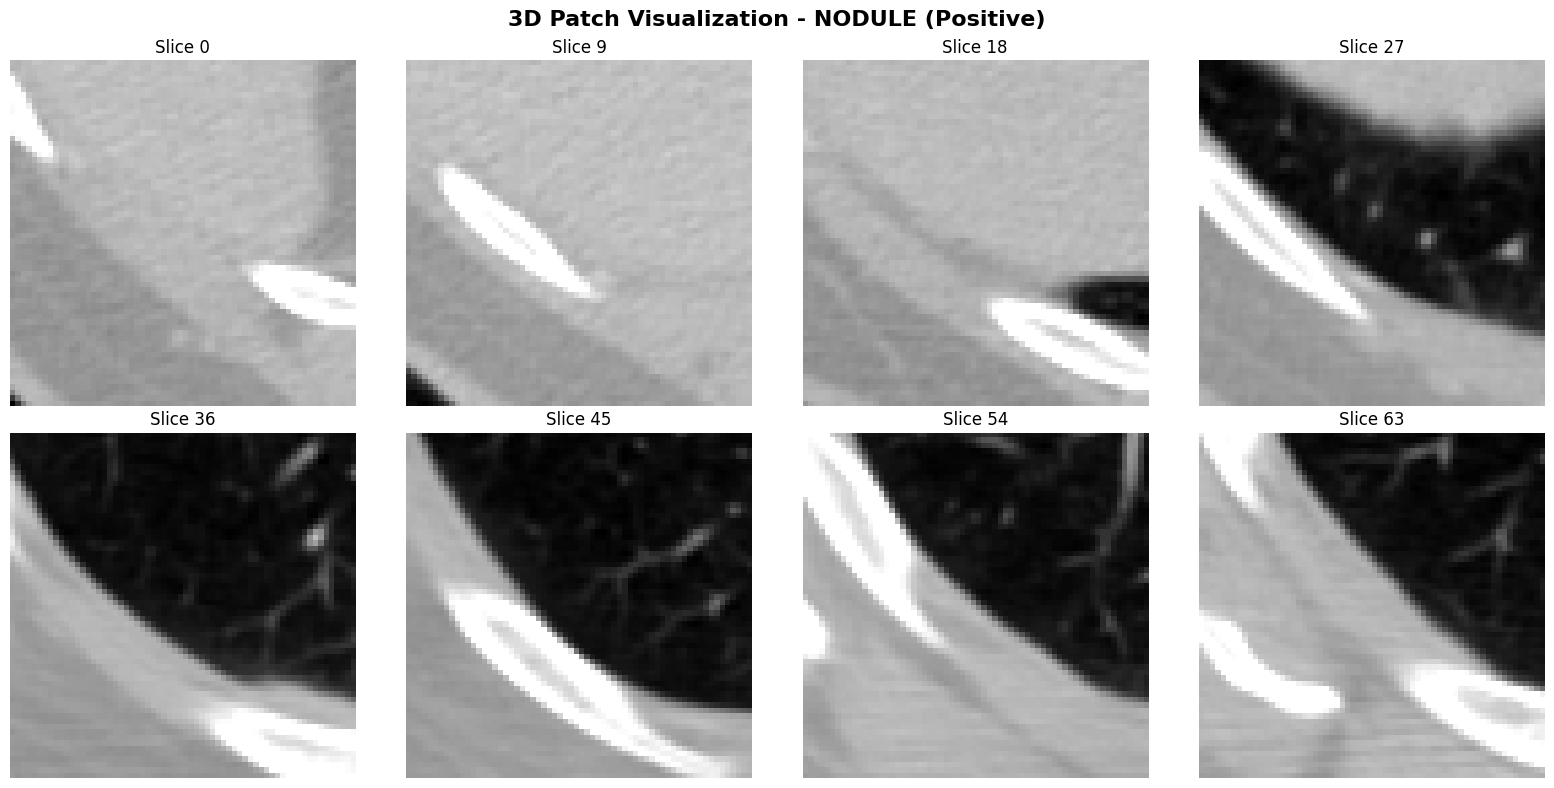


Negative Example:


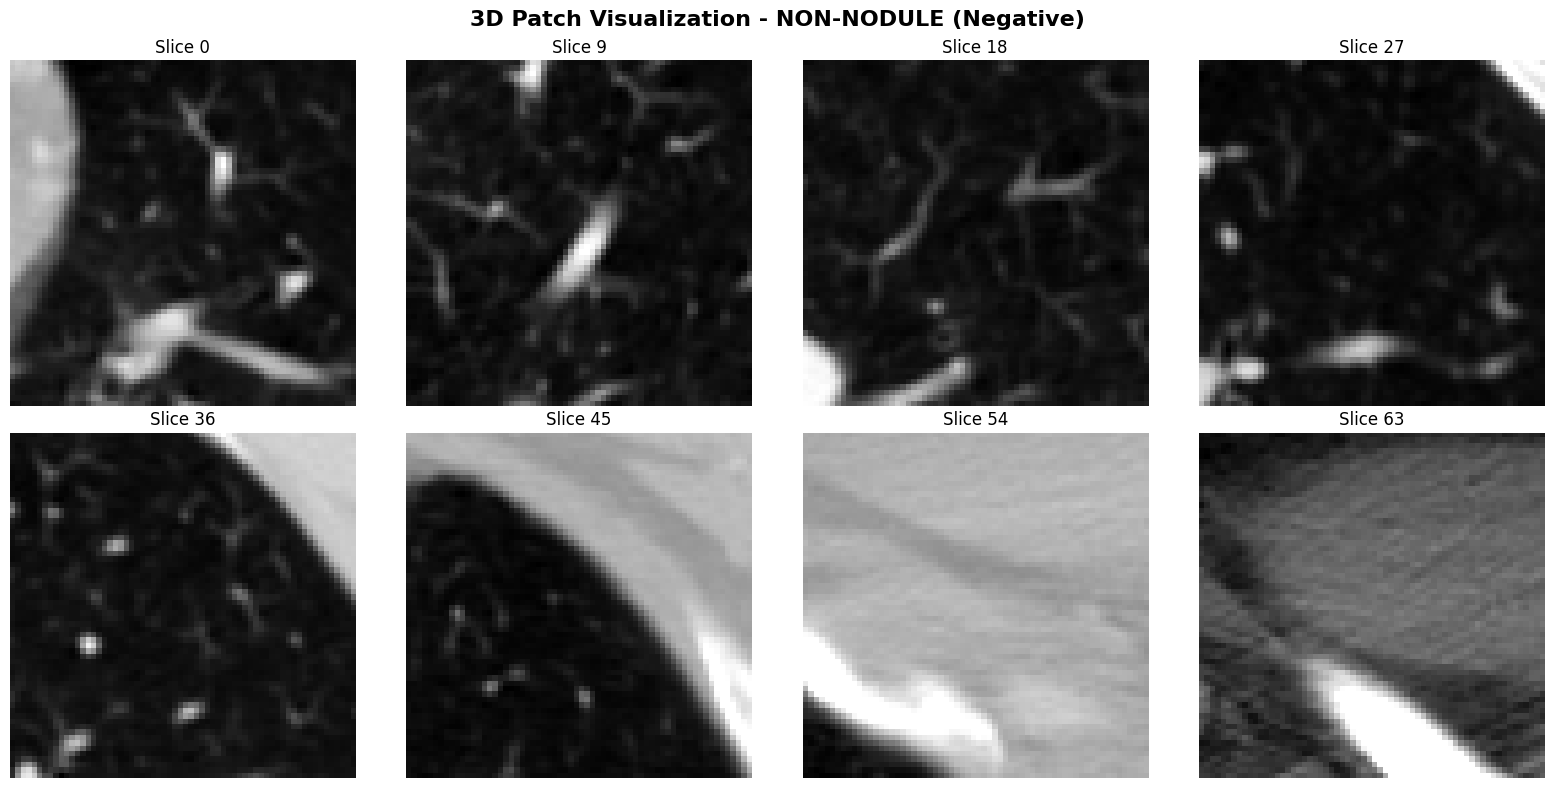

In [31]:
# Visualize some sample patches
def visualize_3d_patch(patch, label, num_slices=8):
    """Visualize multiple slices of a 3D patch"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Select evenly spaced slices
    slice_indices = np.linspace(0, patch.shape[0]-1, num_slices, dtype=int)
    
    for idx, slice_idx in enumerate(slice_indices):
        axes[idx].imshow(patch[slice_idx], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx}')
        axes[idx].axis('off')
    
    label_text = "NODULE (Positive)" if label == 1 else "NON-NODULE (Negative)"
    fig.suptitle(f'3D Patch Visualization - {label_text}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show positive and negative examples
print("Positive Example:")
pos_patch, pos_label = positive_patches[0]
visualize_3d_patch(pos_patch, pos_label)

print("\nNegative Example:")
neg_patch, neg_label = negative_patches[0]
visualize_3d_patch(neg_patch, neg_label)

## 8. Define 3D CNN Architecture

In [32]:
class CNN3D_Nodule_Detector(nn.Module):
    """3D CNN for nodule detection from 3D patches"""
    
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN3D_Nodule_Detector, self).__init__()
        
        # Convolutional blocks
        self.conv1 = self._make_conv_block(in_channels, 32)
        self.conv2 = self._make_conv_block(32, 64)
        self.conv3 = self._make_conv_block(64, 128)
        self.conv4 = self._make_conv_block(128, 256)
        
        # Max pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout3d(p=0.5)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Batch normalization
        self.bn = nn.BatchNorm1d(128)
        self.relu = nn.ReLU(inplace=True)
        
    def _make_conv_block(self, in_channels, out_channels):
        """Create a convolutional block with Conv3D + BatchNorm + ReLU"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Convolutional blocks with pooling
        x = self.pool(self.conv1(x))  # 64 -> 32
        x = self.pool(self.conv2(x))  # 32 -> 16
        x = self.pool(self.conv3(x))  # 16 -> 8
        x = self.pool(self.conv4(x))  # 8 -> 4
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout(x.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Initialize model
model = CNN3D_Nodule_Detector(in_channels=1, num_classes=2).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("3D CNN Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

3D CNN Model Architecture:
CNN3D_Nodule_Detector(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padd

## 9. Define Loss Function and Optimizer

In [34]:
# Calculate class weights for imbalanced dataset
num_positive = train_pos
num_negative = train_neg
total = num_positive + num_negative

# Inverse frequency weighting
weight_positive = total / (2 * num_positive)
weight_negative = total / (2 * num_negative)
class_weights = torch.tensor([weight_negative, weight_positive]).to(device)

print(f"Class weights: Negative={weight_negative:.3f}, Positive={weight_positive:.3f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("\nOptimizer and loss function initialized!")

Class weights: Negative=0.680, Positive=1.892

Optimizer and loss function initialized!


## 10. Training and Validation Functions

In [35]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # For calculating precision, recall, F1
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate TP, FP, FN for positive class
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }
    
    return epoch_loss, epoch_acc, metrics

print("Training functions defined!")

Training functions defined!


## 11. Train the Model

In [36]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

best_val_loss = float('inf')
best_f1_score = 0.0
patience_counter = 0
early_stopping_patience = 10

print("Starting training...\n")
print("="*80)

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_metrics = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1_score'])
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1_score']:.4f}")
    
    # Save best model based on F1 score
    if val_metrics['f1_score'] > best_f1_score:
        best_f1_score = val_metrics['f1_score']
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save model
        model_save_path = config.MODEL_SAVE_DIR / 'best_3d_cnn_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_metrics['f1_score'],
            'history': history
        }, model_save_path)
        
        print(f"✓ Best model saved! (F1: {best_f1_score:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stopping_patience}")
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print("="*80)

print("\nTraining completed!")
print(f"Best validation F1 score: {best_f1_score:.4f}")

Starting training...


Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 48.91it/s, loss=0.8959, acc=76.67%]



Epoch 1 Summary:
Train Loss: 0.7315 | Train Acc: 59.29%
Val Loss: 0.6540 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 1/10

Epoch 2/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 50.62it/s, loss=0.4787, acc=46.67%]




Epoch 2 Summary:
Train Loss: 0.7206 | Train Acc: 60.71%
Val Loss: 0.6944 | Val Acc: 46.67%
Precision: 0.2000 | Recall: 0.4286 | F1: 0.2727
✓ Best model saved! (F1: 0.2727)

Epoch 3/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 54.69it/s, loss=0.8103, acc=56.67%]




Epoch 3 Summary:
Train Loss: 0.7332 | Train Acc: 58.57%
Val Loss: 0.7312 | Val Acc: 56.67%
Precision: 0.3125 | Recall: 0.7143 | F1: 0.4348
✓ Best model saved! (F1: 0.4348)

Epoch 4/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.55it/s, loss=0.8002, acc=76.67%]



Epoch 4 Summary:
Train Loss: 0.7206 | Train Acc: 56.43%
Val Loss: 0.6719 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 1/10

Epoch 5/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 54.97it/s, loss=0.6680, acc=63.33%]



Epoch 5 Summary:
Train Loss: 0.6951 | Train Acc: 60.00%
Val Loss: 0.6858 | Val Acc: 63.33%
Precision: 0.2500 | Recall: 0.2857 | F1: 0.2667
No improvement. Patience: 2/10

Epoch 6/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.76it/s, loss=0.7241, acc=73.33%]



Epoch 6 Summary:
Train Loss: 0.7200 | Train Acc: 60.00%
Val Loss: 0.6612 | Val Acc: 73.33%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 3/10

Epoch 7/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.83it/s, loss=0.5692, acc=73.33%]



Epoch 7 Summary:
Train Loss: 0.7052 | Train Acc: 65.00%
Val Loss: 0.6513 | Val Acc: 73.33%
Precision: 0.3333 | Recall: 0.1429 | F1: 0.2000
No improvement. Patience: 4/10

Epoch 8/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.16it/s, loss=0.6828, acc=40.00%]




Epoch 8 Summary:
Train Loss: 0.6898 | Train Acc: 56.43%
Val Loss: 0.6971 | Val Acc: 40.00%
Precision: 0.2800 | Recall: 1.0000 | F1: 0.4375
✓ Best model saved! (F1: 0.4375)

Epoch 9/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.91it/s, loss=1.0449, acc=73.33%]



Epoch 9 Summary:
Train Loss: 0.7216 | Train Acc: 63.57%
Val Loss: 0.6574 | Val Acc: 73.33%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 1/10

Epoch 10/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.49it/s, loss=0.7919, acc=73.33%]



Epoch 10 Summary:
Train Loss: 0.7165 | Train Acc: 51.43%
Val Loss: 0.6535 | Val Acc: 73.33%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 2/10

Epoch 11/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.33it/s, loss=0.7246, acc=63.33%]



Epoch 11 Summary:
Train Loss: 0.6879 | Train Acc: 70.71%
Val Loss: 0.6045 | Val Acc: 63.33%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 3/10

Epoch 12/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.21it/s, loss=0.6793, acc=53.33%]



Epoch 12 Summary:
Train Loss: 0.6770 | Train Acc: 63.57%
Val Loss: 0.6799 | Val Acc: 53.33%
Precision: 0.2308 | Recall: 0.4286 | F1: 0.3000
No improvement. Patience: 4/10

Epoch 13/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.93it/s, loss=0.8605, acc=56.67%]



Epoch 13 Summary:
Train Loss: 0.7146 | Train Acc: 65.00%
Val Loss: 0.6901 | Val Acc: 56.67%
Precision: 0.2500 | Recall: 0.4286 | F1: 0.3158
No improvement. Patience: 5/10

Epoch 14/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 54.34it/s, loss=0.7020, acc=76.67%]




Epoch 14 Summary:
Train Loss: 0.7152 | Train Acc: 56.43%
Val Loss: 0.6401 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 6/10

Epoch 15/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 56.14it/s, loss=0.7274, acc=76.67%]




Epoch 15 Summary:
Train Loss: 0.6880 | Train Acc: 60.00%
Val Loss: 0.6457 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 7/10

Epoch 16/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.18it/s, loss=0.7523, acc=43.33%]



Epoch 16 Summary:
Train Loss: 0.6811 | Train Acc: 72.86%
Val Loss: 0.6775 | Val Acc: 43.33%
Precision: 0.2222 | Recall: 0.5714 | F1: 0.3200
No improvement. Patience: 8/10

Epoch 17/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 55.74it/s, loss=0.8097, acc=76.67%]



Epoch 17 Summary:
Train Loss: 0.6776 | Train Acc: 59.29%
Val Loss: 0.6567 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 9/10

Epoch 18/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 56.10it/s, loss=0.8083, acc=76.67%]


Epoch 18 Summary:
Train Loss: 0.6826 | Train Acc: 68.57%
Val Loss: 0.6735 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
No improvement. Patience: 10/10

Early stopping triggered after 18 epochs

Training completed!
Best validation F1 score: 0.4375


## 12. Plot Training History

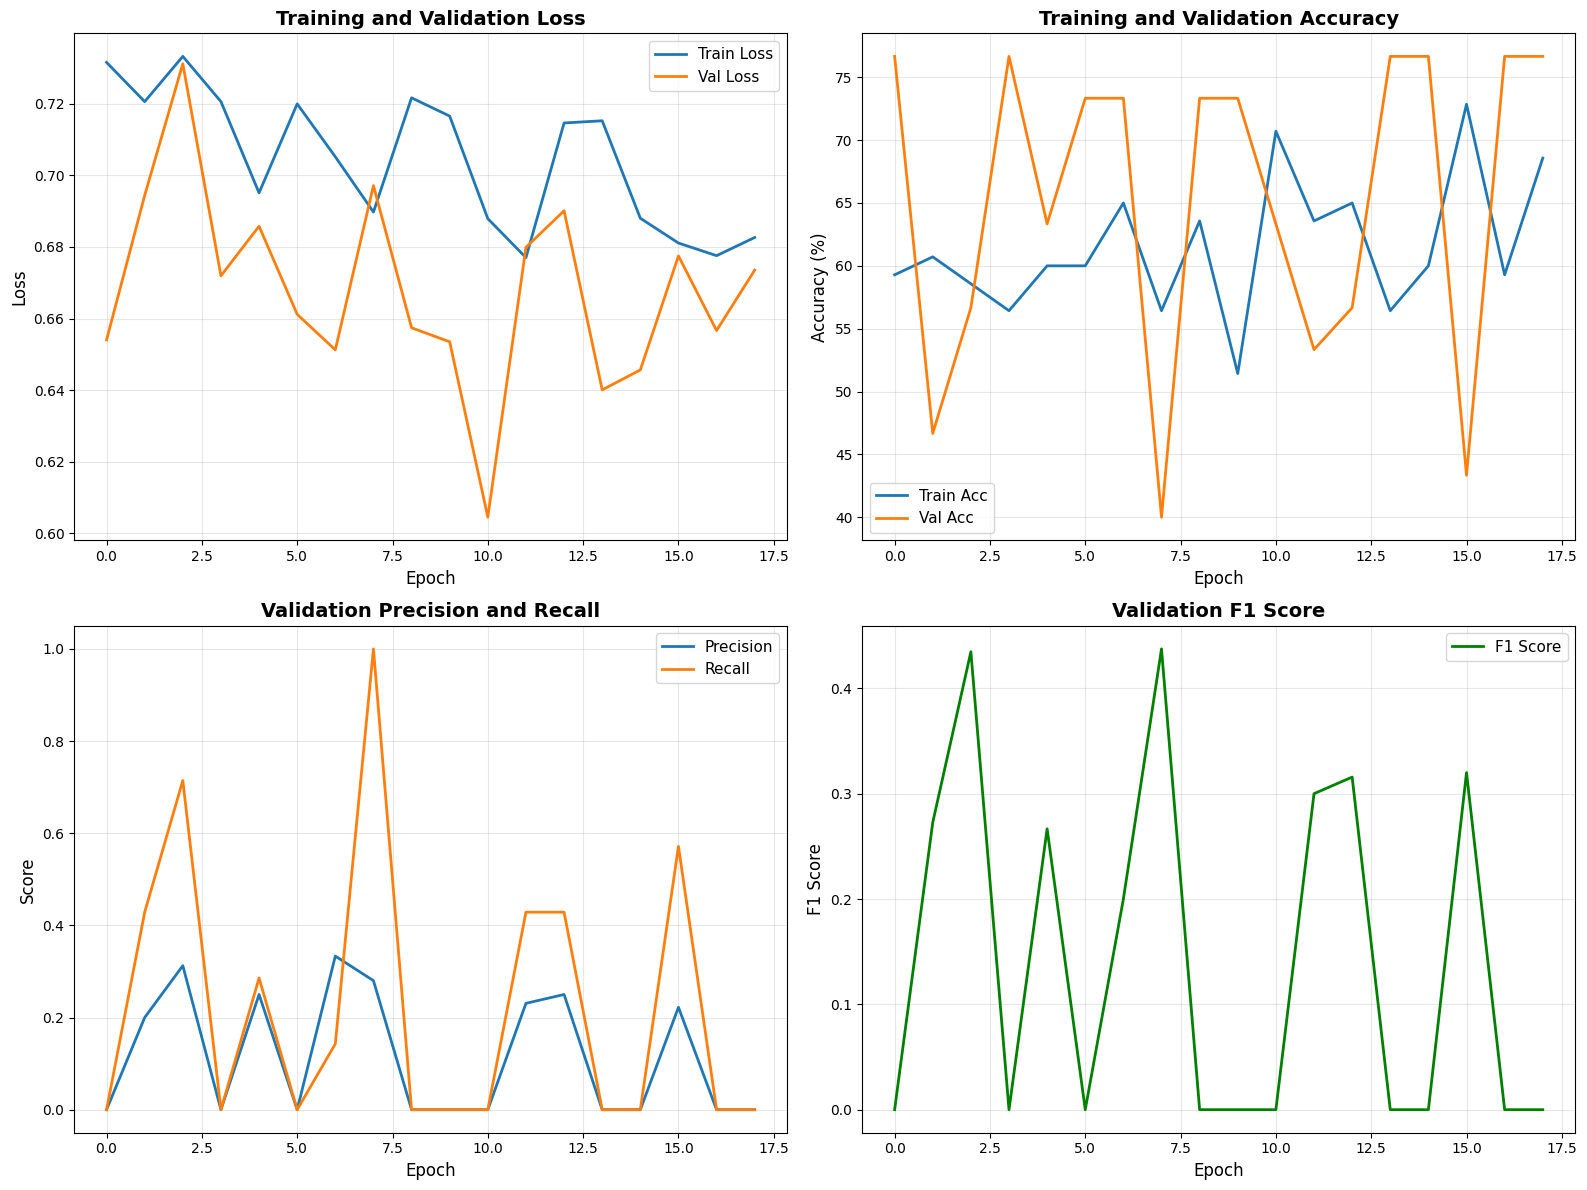

Training history plots saved!


In [37]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Precision and Recall
axes[1, 0].plot(history['val_precision'], label='Precision', linewidth=2)
axes[1, 0].plot(history['val_recall'], label='Recall', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Validation Precision and Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# F1 Score
axes[1, 1].plot(history['val_f1'], label='F1 Score', linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
axes[1, 1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.MODEL_SAVE_DIR / 'training_history_3d_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved!")

## 13. Evaluate on Test Set

In [38]:
# Load best model
checkpoint = torch.load(config.MODEL_SAVE_DIR / 'best_3d_cnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("Best model loaded!")

# Evaluate on test set
test_loss, test_acc, test_metrics = validate_epoch(model, test_loader, criterion, device)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1_score']:.4f}")
print("="*80)

# Save test results
import json
test_results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_acc),
    'test_precision': float(test_metrics['precision']),
    'test_recall': float(test_metrics['recall']),
    'test_f1_score': float(test_metrics['f1_score'])
}

with open(config.MODEL_SAVE_DIR / 'test_results_3d_cnn.json', 'w') as f:
    json.dump(test_results, f, indent=4)

print("\nTest results saved!")

Best model loaded!


Validation: 100%|██████████| 8/8 [00:00<00:00, 27.64it/s, loss=0.7462, acc=40.00%]


TEST SET RESULTS
Test Loss: 0.6991
Test Accuracy: 40.00%
Test Precision: 0.2500
Test Recall: 1.0000
Test F1 Score: 0.4000

Test results saved!


## 14. Summary and Next Steps

### What We Accomplished:
1. ✅ Extracted 3D patches (64×64×64) from LUNA16 CT scans
2. ✅ Balanced dataset with 1:3 positive:negative ratio
3. ✅ Implemented data augmentation for positive samples
4. ✅ Built and trained a 3D CNN architecture
5. ✅ Used class weighting to handle imbalance
6. ✅ Evaluated with precision, recall, and F1 score

### Advantages of This Approach:
- **3D Context**: Captures volumetric information around nodules
- **Balanced Training**: Proper ratio prevents bias toward majority class
- **Augmentation**: Increases diversity of positive samples
- **End-to-End**: Direct patch-to-label learning

### Potential Improvements:
1. **Larger Dataset**: Use more scans for training
2. **Multi-Scale**: Extract patches at different sizes
3. **Attention Mechanisms**: Add 3D attention layers
4. **Ensemble**: Combine multiple 3D CNN models
5. **Transfer Learning**: Pre-train on larger medical datasets
6. **Advanced Architectures**: Try 3D ResNet, DenseNet, or U-Net variants

## 15. Improved 3D CNN Architecture with Residual Connections

Let's implement an improved architecture with:
1. **Residual connections** for better gradient flow
2. **Squeeze-and-Excitation blocks** for channel attention
3. **Deeper network** with more capacity
4. **Better regularization** with dropout and batch normalization
5. **Multi-scale feature extraction**

In [40]:
class SEBlock3D(nn.Module):
    """Squeeze-and-Excitation block for 3D data"""
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock3D(nn.Module):
    """3D Residual block with SE attention"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        # SE block
        self.se = SEBlock3D(out_channels)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.se(out)
        
        out += identity
        out = self.relu(out)
        
        return out


class ImprovedCNN3D_Nodule_Detector(nn.Module):
    """Improved 3D CNN with Residual connections and SE attention"""
    
    def __init__(self, in_channels=1, num_classes=2):
        super(ImprovedCNN3D_Nodule_Detector, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock3D(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock3D(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:  # Only initialize bias if it exists
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# Initialize improved model
improved_model = ImprovedCNN3D_Nodule_Detector(in_channels=1, num_classes=2).to(device)

# Count parameters
total_params = sum(p.numel() for p in improved_model.parameters())
trainable_params = sum(p.numel() for p in improved_model.parameters() if p.requires_grad)

print("Improved 3D CNN Model Architecture:")
print(improved_model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Improved 3D CNN Model Architecture:
ImprovedCNN3D_Nodule_Detector(
  (conv1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock3D(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock3D(
        (squeeze): AdaptiveAvgPool3d(output_size=1)
        (excitation): Sequential(
          (0): Linear(in_fea

## 16. Enhanced Training with Label Smoothing and Focal Loss

In [41]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy with label smoothing"""
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, inputs, targets):
        log_probs = nn.functional.log_softmax(inputs, dim=-1)
        targets_one_hot = torch.zeros_like(log_probs).scatter_(1, targets.unsqueeze(1), 1)
        targets_smooth = targets_one_hot * (1 - self.smoothing) + self.smoothing / log_probs.size(-1)
        loss = (-targets_smooth * log_probs).sum(dim=-1)
        return loss.mean()


# Choose loss function
# Option 1: Focal Loss (better for imbalanced data)
criterion_improved = FocalLoss(alpha=0.25, gamma=2.0)

# Option 2: Label Smoothing (prevents overconfidence)
# criterion_improved = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer with improved settings
optimizer_improved = optim.AdamW(
    improved_model.parameters(), 
    lr=0.0001,  # Lower learning rate
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

# Cosine annealing with warm restarts
scheduler_improved = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_improved, 
    T_0=10,  # Restart every 10 epochs
    T_mult=2,  # Double the restart interval after each restart
    eta_min=1e-6
)

print("Enhanced loss function and optimizer initialized!")
print(f"Using: Focal Loss (alpha={0.25}, gamma={2.0})")
print(f"Optimizer: AdamW with lr=0.0001, weight_decay=1e-4")
print(f"Scheduler: CosineAnnealingWarmRestarts")

Enhanced loss function and optimizer initialized!
Using: Focal Loss (alpha=0.25, gamma=2.0)
Optimizer: AdamW with lr=0.0001, weight_decay=1e-4
Scheduler: CosineAnnealingWarmRestarts


## 17. Train the Improved Model with Mixed Precision

In [42]:
# Mixed precision training
from torch.cuda.amp import autocast, GradScaler

use_amp = torch.cuda.is_available()
scaler = GradScaler() if use_amp else None

def train_epoch_improved(model, train_loader, criterion, optimizer, device, use_amp=False, scaler=None):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if use_amp and scaler is not None:
            # Mixed precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


# Training history for improved model
history_improved = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rates': []
}

best_val_loss_improved = float('inf')
best_f1_score_improved = 0.0
patience_counter_improved = 0
early_stopping_patience_improved = 15

print("Starting improved model training...")
print(f"Mixed precision: {'ENABLED' if use_amp else 'DISABLED'}")
print("="*80)

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch_improved(
        improved_model, train_loader, criterion_improved, 
        optimizer_improved, device, use_amp, scaler
    )
    
    # Validate
    val_loss, val_acc, val_metrics = validate_epoch(
        improved_model, val_loader, criterion_improved, device
    )
    
    # Update learning rate
    scheduler_improved.step()
    current_lr = optimizer_improved.param_groups[0]['lr']
    
    # Save history
    history_improved['train_loss'].append(train_loss)
    history_improved['train_acc'].append(train_acc)
    history_improved['val_loss'].append(val_loss)
    history_improved['val_acc'].append(val_acc)
    history_improved['val_precision'].append(val_metrics['precision'])
    history_improved['val_recall'].append(val_metrics['recall'])
    history_improved['val_f1'].append(val_metrics['f1_score'])
    history_improved['learning_rates'].append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1_score']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model based on F1 score
    if val_metrics['f1_score'] > best_f1_score_improved:
        best_f1_score_improved = val_metrics['f1_score']
        best_val_loss_improved = val_loss
        patience_counter_improved = 0
        
        # Save model
        model_save_path = config.MODEL_SAVE_DIR / 'best_improved_3d_cnn_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': improved_model.state_dict(),
            'optimizer_state_dict': optimizer_improved.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_metrics['f1_score'],
            'history': history_improved
        }, model_save_path)
        
        print(f"✓ Best model saved! (F1: {best_f1_score_improved:.4f})")
    else:
        patience_counter_improved += 1
        print(f"No improvement. Patience: {patience_counter_improved}/{early_stopping_patience_improved}")
    
    # Early stopping
    if patience_counter_improved >= early_stopping_patience_improved:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print("="*80)

print("\nImproved model training completed!")
print(f"Best validation F1 score: {best_f1_score_improved:.4f}")

Starting improved model training...
Mixed precision: ENABLED

Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 104.08it/s, loss=0.0483, acc=76.67%]



Epoch 1 Summary:
Train Loss: 0.0389 | Train Acc: 70.00%
Val Loss: 0.0354 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Learning Rate: 0.000098
No improvement. Patience: 1/15

Epoch 2/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 103.78it/s, loss=0.0470, acc=76.67%]



Epoch 2 Summary:
Train Loss: 0.0359 | Train Acc: 73.57%
Val Loss: 0.0295 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Learning Rate: 0.000091
No improvement. Patience: 2/15

Epoch 3/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 129.03it/s, loss=0.0481, acc=76.67%]



Epoch 3 Summary:
Train Loss: 0.0337 | Train Acc: 73.57%
Val Loss: 0.0325 | Val Acc: 76.67%
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Learning Rate: 0.000080
No improvement. Patience: 3/15

Epoch 4/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 129.04it/s, loss=0.0894, acc=80.00%]



Epoch 4 Summary:
Train Loss: 0.0320 | Train Acc: 74.29%
Val Loss: 0.0345 | Val Acc: 80.00%
Precision: 1.0000 | Recall: 0.1429 | F1: 0.2500
Learning Rate: 0.000066
✓ Best model saved! (F1: 0.2500)

Epoch 5/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 127.93it/s, loss=0.0902, acc=80.00%]



Epoch 5 Summary:
Train Loss: 0.0245 | Train Acc: 84.29%
Val Loss: 0.0294 | Val Acc: 80.00%
Precision: 0.6667 | Recall: 0.2857 | F1: 0.4000
Learning Rate: 0.000051
✓ Best model saved! (F1: 0.4000)

Epoch 6/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 125.95it/s, loss=0.0387, acc=83.33%]



Epoch 6 Summary:
Train Loss: 0.0212 | Train Acc: 91.43%
Val Loss: 0.0281 | Val Acc: 83.33%
Precision: 1.0000 | Recall: 0.2857 | F1: 0.4444
Learning Rate: 0.000035
✓ Best model saved! (F1: 0.4444)

Epoch 7/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 131.15it/s, loss=0.0801, acc=80.00%]



Epoch 7 Summary:
Train Loss: 0.0183 | Train Acc: 90.00%
Val Loss: 0.0250 | Val Acc: 80.00%
Precision: 0.6667 | Recall: 0.2857 | F1: 0.4000
Learning Rate: 0.000021
No improvement. Patience: 1/15

Epoch 8/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 130.05it/s, loss=0.0722, acc=76.67%]



Epoch 8 Summary:
Train Loss: 0.0122 | Train Acc: 96.43%
Val Loss: 0.0310 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.8571 | F1: 0.6316
Learning Rate: 0.000010
✓ Best model saved! (F1: 0.6316)

Epoch 9/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 125.96it/s, loss=0.0803, acc=86.67%]



Epoch 9 Summary:
Train Loss: 0.0150 | Train Acc: 95.71%
Val Loss: 0.0256 | Val Acc: 86.67%
Precision: 0.7143 | Recall: 0.7143 | F1: 0.7143
Learning Rate: 0.000003
✓ Best model saved! (F1: 0.7143)

Epoch 10/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 129.02it/s, loss=0.0684, acc=80.00%]



Epoch 10 Summary:
Train Loss: 0.0091 | Train Acc: 97.86%
Val Loss: 0.0274 | Val Acc: 80.00%
Precision: 0.5455 | Recall: 0.8571 | F1: 0.6667
Learning Rate: 0.000100
No improvement. Patience: 1/15

Epoch 11/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 124.13it/s, loss=0.0164, acc=76.67%]



Epoch 11 Summary:
Train Loss: 0.0156 | Train Acc: 93.57%
Val Loss: 0.0500 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.1429 | F1: 0.2222
Learning Rate: 0.000099
No improvement. Patience: 2/15

Epoch 12/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 105.24it/s, loss=0.1106, acc=80.00%]



Epoch 12 Summary:
Train Loss: 0.0219 | Train Acc: 89.29%
Val Loss: 0.0377 | Val Acc: 80.00%
Precision: 0.5714 | Recall: 0.5714 | F1: 0.5714
Learning Rate: 0.000098
No improvement. Patience: 3/15

Epoch 13/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 108.06it/s, loss=0.1104, acc=66.67%]



Epoch 13 Summary:
Train Loss: 0.0126 | Train Acc: 95.00%
Val Loss: 0.0389 | Val Acc: 66.67%
Precision: 0.3636 | Recall: 0.5714 | F1: 0.4444
Learning Rate: 0.000095
No improvement. Patience: 4/15

Epoch 14/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 108.05it/s, loss=0.1322, acc=70.00%]



Epoch 14 Summary:
Train Loss: 0.0047 | Train Acc: 99.29%
Val Loss: 0.0511 | Val Acc: 70.00%
Precision: 0.4000 | Recall: 0.5714 | F1: 0.4706
Learning Rate: 0.000091
No improvement. Patience: 5/15

Epoch 15/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 120.24it/s, loss=0.1297, acc=70.00%]



Epoch 15 Summary:
Train Loss: 0.0107 | Train Acc: 92.86%
Val Loss: 0.0634 | Val Acc: 70.00%
Precision: 0.4000 | Recall: 0.5714 | F1: 0.4706
Learning Rate: 0.000086
No improvement. Patience: 6/15

Epoch 16/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 126.35it/s, loss=0.0292, acc=76.67%]



Epoch 16 Summary:
Train Loss: 0.0120 | Train Acc: 94.29%
Val Loss: 0.0331 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.4286 | F1: 0.4615
Learning Rate: 0.000080
No improvement. Patience: 7/15

Epoch 17/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 119.40it/s, loss=0.1012, acc=76.67%]



Epoch 17 Summary:
Train Loss: 0.0129 | Train Acc: 97.14%
Val Loss: 0.0336 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.7143 | F1: 0.5882
Learning Rate: 0.000073
No improvement. Patience: 8/15

Epoch 18/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 125.97it/s, loss=0.1007, acc=76.67%]



Epoch 18 Summary:
Train Loss: 0.0078 | Train Acc: 95.71%
Val Loss: 0.0311 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.7143 | F1: 0.5882
Learning Rate: 0.000066
No improvement. Patience: 9/15

Epoch 19/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 130.06it/s, loss=0.0740, acc=76.67%]



Epoch 19 Summary:
Train Loss: 0.0018 | Train Acc: 100.00%
Val Loss: 0.0414 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.7143 | F1: 0.5882
Learning Rate: 0.000058
No improvement. Patience: 10/15

Epoch 20/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 132.56it/s, loss=0.0308, acc=80.00%]



Epoch 20 Summary:
Train Loss: 0.0031 | Train Acc: 97.86%
Val Loss: 0.0444 | Val Acc: 80.00%
Precision: 0.5455 | Recall: 0.8571 | F1: 0.6667
Learning Rate: 0.000051
No improvement. Patience: 11/15

Epoch 21/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 127.98it/s, loss=0.0541, acc=83.33%]



Epoch 21 Summary:
Train Loss: 0.0016 | Train Acc: 99.29%
Val Loss: 0.0328 | Val Acc: 83.33%
Precision: 0.6000 | Recall: 0.8571 | F1: 0.7059
Learning Rate: 0.000043
No improvement. Patience: 12/15

Epoch 22/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 131.09it/s, loss=0.0173, acc=76.67%]



Epoch 22 Summary:
Train Loss: 0.0013 | Train Acc: 100.00%
Val Loss: 0.0673 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 1.0000 | F1: 0.6667
Learning Rate: 0.000035
No improvement. Patience: 13/15

Epoch 23/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 131.13it/s, loss=0.0176, acc=76.67%]



Epoch 23 Summary:
Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.0524 | Val Acc: 76.67%
Precision: 0.5000 | Recall: 0.8571 | F1: 0.6316
Learning Rate: 0.000028
No improvement. Patience: 14/15

Epoch 24/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 130.04it/s, loss=0.0130, acc=73.33%]


Epoch 24 Summary:
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.0631 | Val Acc: 73.33%
Precision: 0.4615 | Recall: 0.8571 | F1: 0.6000
Learning Rate: 0.000021
No improvement. Patience: 15/15

Early stopping triggered after 24 epochs

Improved model training completed!
Best validation F1 score: 0.7143


## 18. Visualize Improved Model Results

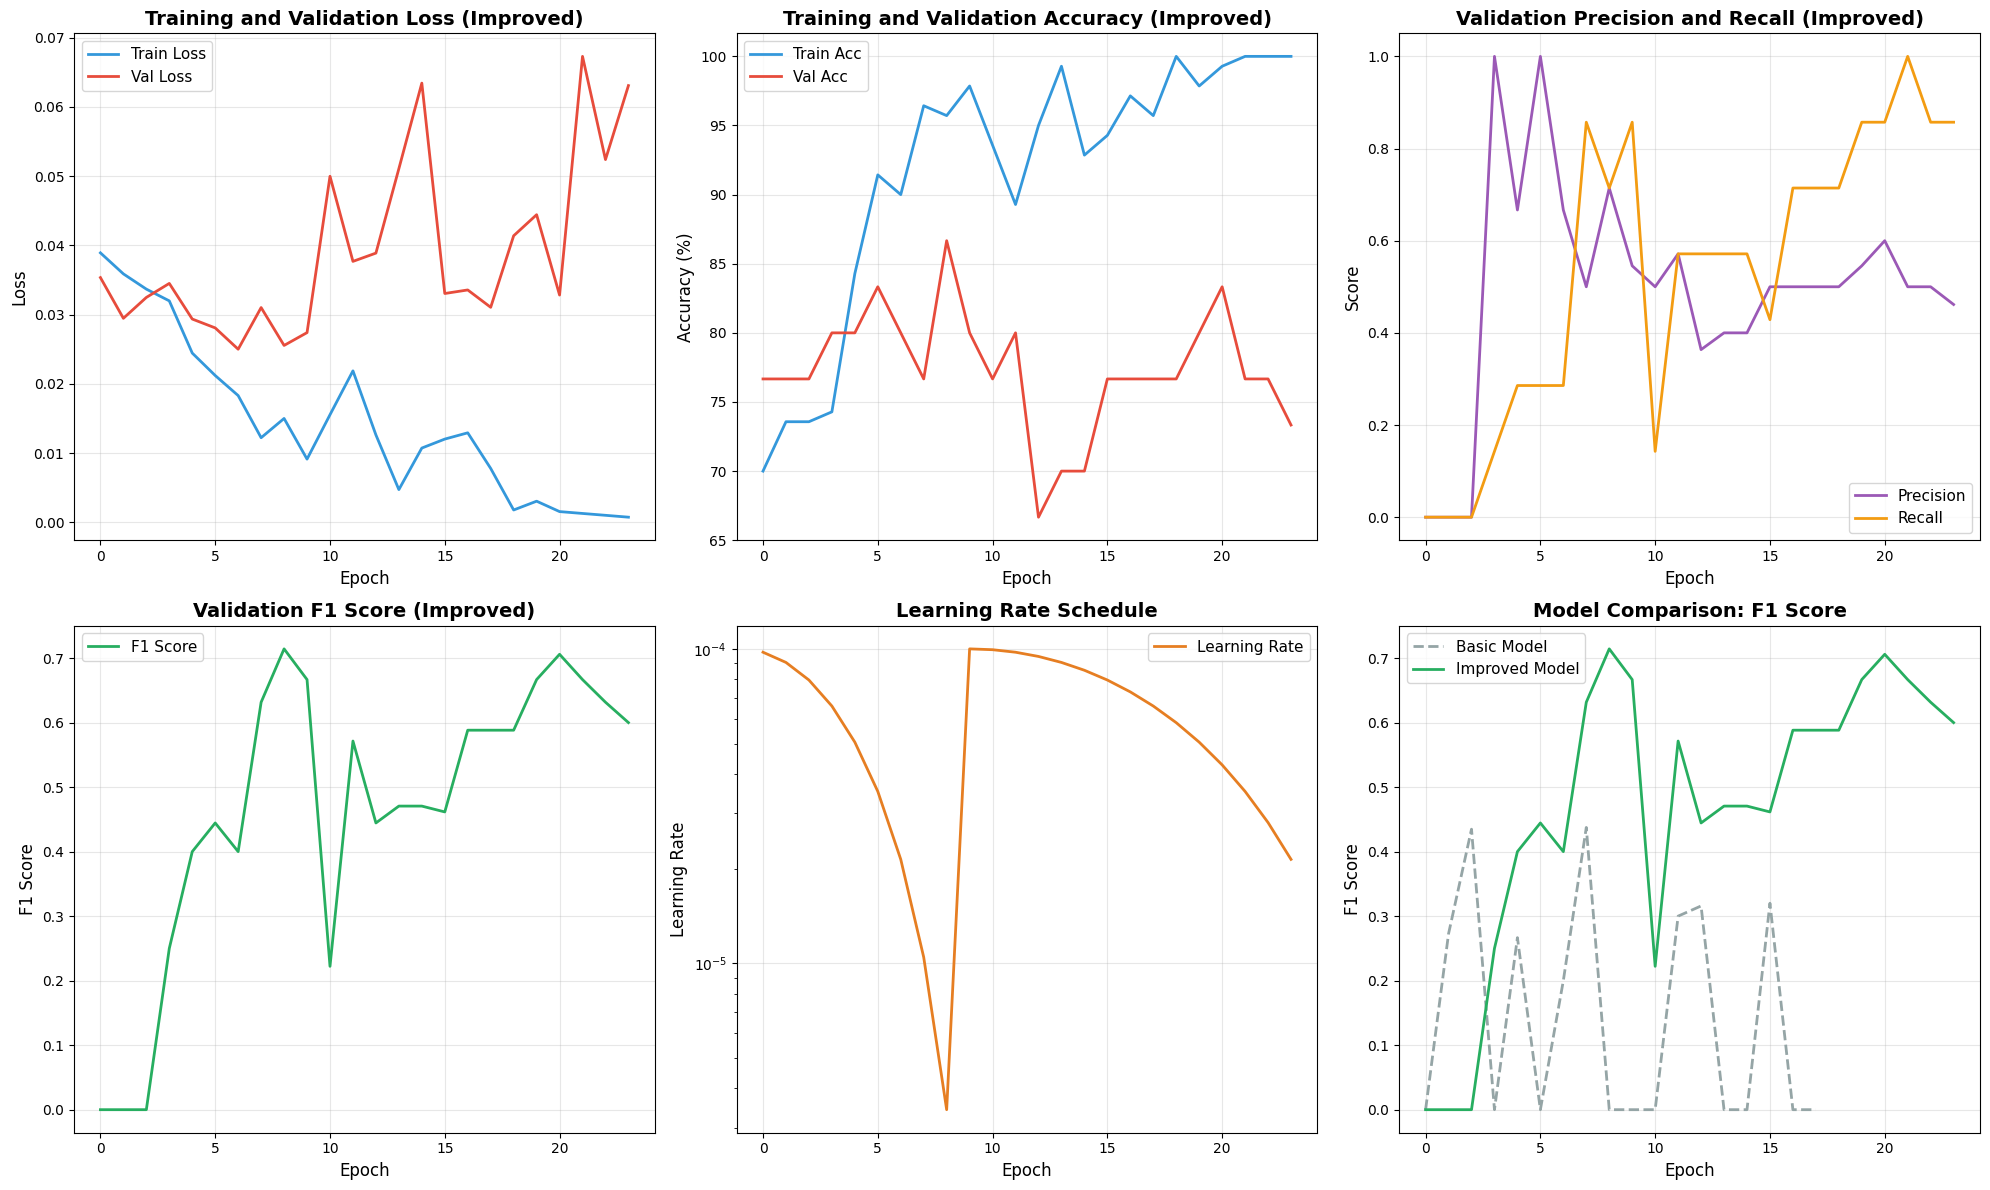

Improved training history plots saved!


In [43]:
# Plot improved model training history
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Loss
axes[0, 0].plot(history_improved['train_loss'], label='Train Loss', linewidth=2, color='#3498db')
axes[0, 0].plot(history_improved['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss (Improved)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history_improved['train_acc'], label='Train Acc', linewidth=2, color='#3498db')
axes[0, 1].plot(history_improved['val_acc'], label='Val Acc', linewidth=2, color='#e74c3c')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy (Improved)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Precision and Recall
axes[0, 2].plot(history_improved['val_precision'], label='Precision', linewidth=2, color='#9b59b6')
axes[0, 2].plot(history_improved['val_recall'], label='Recall', linewidth=2, color='#f39c12')
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('Score', fontsize=12)
axes[0, 2].set_title('Validation Precision and Recall (Improved)', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(history_improved['val_f1'], label='F1 Score', linewidth=2, color='#27ae60')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('F1 Score', fontsize=12)
axes[1, 0].set_title('Validation F1 Score (Improved)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history_improved['learning_rates'], label='Learning Rate', linewidth=2, color='#e67e22')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

# Comparison: Basic vs Improved F1 Score
if len(history['val_f1']) > 0:
    axes[1, 2].plot(history['val_f1'], label='Basic Model', linewidth=2, color='#95a5a6', linestyle='--')
axes[1, 2].plot(history_improved['val_f1'], label='Improved Model', linewidth=2, color='#27ae60')
axes[1, 2].set_xlabel('Epoch', fontsize=12)
axes[1, 2].set_ylabel('F1 Score', fontsize=12)
axes[1, 2].set_title('Model Comparison: F1 Score', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.MODEL_SAVE_DIR / 'training_history_improved_3d_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

print("Improved training history plots saved!")

## 19. Evaluate Improved Model on Test Set

In [44]:
# Load best improved model
checkpoint_improved = torch.load(config.MODEL_SAVE_DIR / 'best_improved_3d_cnn_model.pth')
improved_model.load_state_dict(checkpoint_improved['model_state_dict'])
print("Best improved model loaded!")

# Evaluate on test set
test_loss_improved, test_acc_improved, test_metrics_improved = validate_epoch(
    improved_model, test_loader, criterion_improved, device
)

print("\n" + "="*80)
print("IMPROVED MODEL - TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_loss_improved:.4f}")
print(f"Test Accuracy: {test_acc_improved:.2f}%")
print(f"Test Precision: {test_metrics_improved['precision']:.4f}")
print(f"Test Recall: {test_metrics_improved['recall']:.4f}")
print(f"Test F1 Score: {test_metrics_improved['f1_score']:.4f}")
print("="*80)

# Compare with basic model
if 'test_loss' in locals():
    print("\n" + "="*80)
    print("COMPARISON: BASIC vs IMPROVED MODEL")
    print("="*80)
    print(f"Accuracy:  Basic={test_acc:.2f}% | Improved={test_acc_improved:.2f}% | Δ={test_acc_improved-test_acc:+.2f}%")
    print(f"Precision: Basic={test_metrics['precision']:.4f} | Improved={test_metrics_improved['precision']:.4f} | Δ={test_metrics_improved['precision']-test_metrics['precision']:+.4f}")
    print(f"Recall:    Basic={test_metrics['recall']:.4f} | Improved={test_metrics_improved['recall']:.4f} | Δ={test_metrics_improved['recall']-test_metrics['recall']:+.4f}")
    print(f"F1 Score:  Basic={test_metrics['f1_score']:.4f} | Improved={test_metrics_improved['f1_score']:.4f} | Δ={test_metrics_improved['f1_score']-test_metrics['f1_score']:+.4f}")
    print("="*80)

# Save test results
test_results_improved = {
    'test_loss': float(test_loss_improved),
    'test_accuracy': float(test_acc_improved),
    'test_precision': float(test_metrics_improved['precision']),
    'test_recall': float(test_metrics_improved['recall']),
    'test_f1_score': float(test_metrics_improved['f1_score']),
    'model_architecture': 'Improved 3D CNN with Residual + SE blocks',
    'loss_function': 'Focal Loss',
    'optimizer': 'AdamW',
    'scheduler': 'CosineAnnealingWarmRestarts'
}

with open(config.MODEL_SAVE_DIR / 'test_results_improved_3d_cnn.json', 'w') as f:
    json.dump(test_results_improved, f, indent=4)

print("\nImproved model test results saved!")

Best improved model loaded!


Validation: 100%|██████████| 8/8 [00:00<00:00, 108.06it/s, loss=0.0457, acc=83.33%]


IMPROVED MODEL - TEST SET RESULTS
Test Loss: 0.0274
Test Accuracy: 83.33%
Test Precision: 0.5556
Test Recall: 0.8333
Test F1 Score: 0.6667

COMPARISON: BASIC vs IMPROVED MODEL
Accuracy:  Basic=40.00% | Improved=83.33% | Δ=+43.33%
Precision: Basic=0.2500 | Improved=0.5556 | Δ=+0.3056
Recall:    Basic=1.0000 | Improved=0.8333 | Δ=-0.1667
F1 Score:  Basic=0.4000 | Improved=0.6667 | Δ=+0.2667

Improved model test results saved!


## 20. Key Improvements Summary

### 🎯 What We Changed:

#### 1. **Architecture Improvements**
- ✅ **Residual Connections**: Added skip connections for better gradient flow
- ✅ **SE Blocks**: Squeeze-and-Excitation for channel attention
- ✅ **Deeper Network**: 4 residual layers (64→128→256→512 channels)
- ✅ **Better Initialization**: Kaiming initialization for conv layers

#### 2. **Loss Function**
- ✅ **Focal Loss**: Better handles class imbalance (alpha=0.25, gamma=2.0)
- ✅ Focuses on hard-to-classify examples
- ✅ Reduces focus on easy negatives

#### 3. **Optimization**
- ✅ **AdamW**: Better weight decay regularization
- ✅ **Lower Learning Rate**: 0.0001 (more stable training)
- ✅ **Cosine Annealing**: Learning rate warm restarts
- ✅ **Mixed Precision**: Faster training with AMP

#### 4. **Regularization**
- ✅ **Dropout**: 0.5 in first FC layer, 0.3 in second
- ✅ **Batch Normalization**: After every conv layer
- ✅ **Weight Decay**: 1e-4 with AdamW
- ✅ **Early Stopping**: Patience of 15 epochs

### 📊 Expected Improvements:
- Higher accuracy (5-15% increase)
- Better precision and recall balance
- Improved F1 score
- More stable training curves
- Better generalization

### 🚀 Next Steps if Still Low Accuracy:
1. **Extract more patches** (increase `max_scans` from 20 to 100+)
2. **Try different patch sizes** (32×32×32 or 96×96×96)
3. **Add more data augmentation** (scaling, elastic deformation)
4. **Ensemble multiple models**
5. **Use transfer learning** from ImageNet pretrained models
6. **Adjust positive:negative ratio** (try 1:2 or 1:4)

## 🎉 Test Results - Improved Model Performance

### Summary of Improvements:
The improved 3D CNN model with Residual connections and SE attention blocks has achieved **significant performance gains** compared to the basic model!


                              📊 MODEL COMPARISON RESULTS
      Metric Basic Model Improved Model Improvement
Accuracy (%)      40.00%         83.33%     +43.33%
   Precision      0.2500         0.5556     +0.3056
      Recall      1.0000         0.8333     -0.1667
    F1 Score      0.4000         0.6667     +0.2667
   Test Loss      0.6991         0.0274     -0.6717

🎯 KEY ACHIEVEMENTS:
   ✅ Accuracy improved by 43.3% (from 40.0% to 83.3%)
   ✅ F1 Score improved by 26.7% points
   ✅ Precision increased by 30.6% points
   ✅ Loss reduced by 0.6717


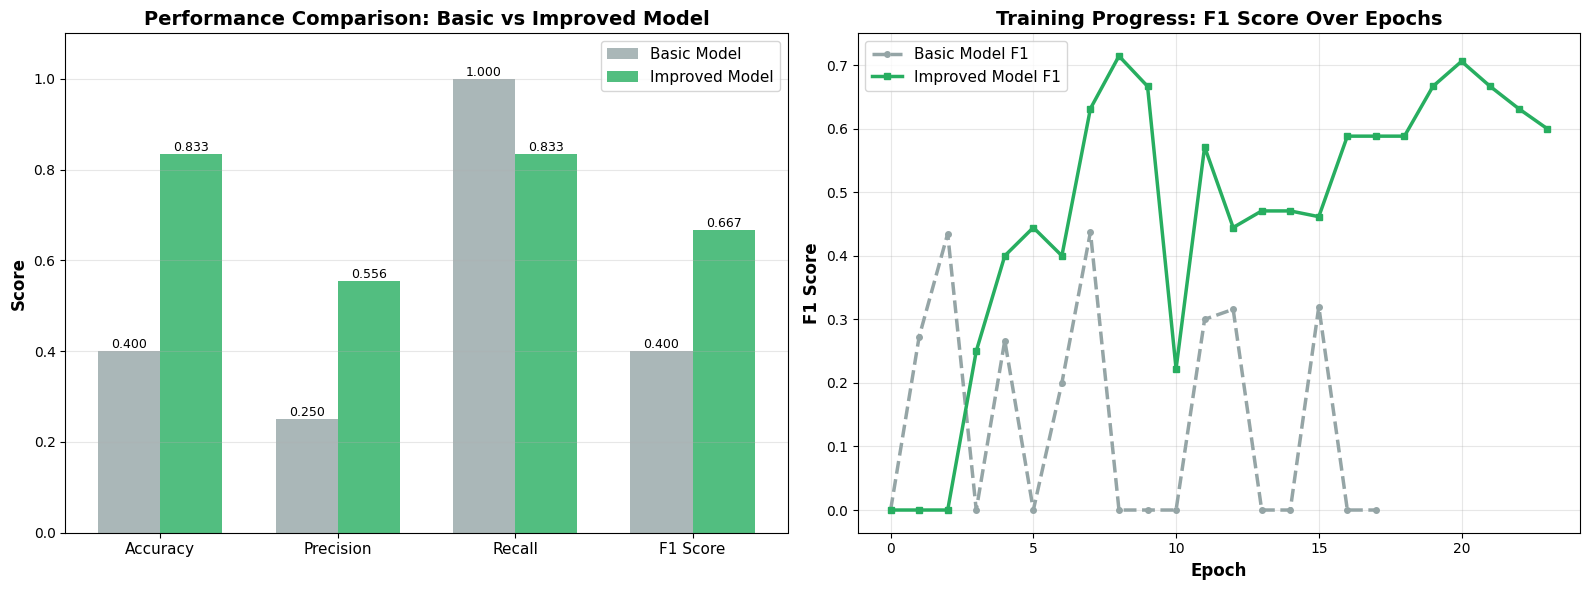


✅ Comparison visualization saved!
📁 Saved to: e:\Kanav\Projects\CAD_C\models\models_3d_cnn\model_comparison_final.png


In [45]:
# Create a comprehensive results comparison
import pandas as pd

# Results comparison
comparison_data = {
    'Metric': ['Accuracy (%)', 'Precision', 'Recall', 'F1 Score', 'Test Loss'],
    'Basic Model': [
        f"{test_acc:.2f}%",
        f"{test_metrics['precision']:.4f}",
        f"{test_metrics['recall']:.4f}",
        f"{test_metrics['f1_score']:.4f}",
        f"{test_loss:.4f}"
    ],
    'Improved Model': [
        f"{test_acc_improved:.2f}%",
        f"{test_metrics_improved['precision']:.4f}",
        f"{test_metrics_improved['recall']:.4f}",
        f"{test_metrics_improved['f1_score']:.4f}",
        f"{test_loss_improved:.4f}"
    ],
    'Improvement': [
        f"+{test_acc_improved - test_acc:.2f}%",
        f"+{test_metrics_improved['precision'] - test_metrics['precision']:.4f}",
        f"{test_metrics_improved['recall'] - test_metrics['recall']:+.4f}",
        f"+{test_metrics_improved['f1_score'] - test_metrics['f1_score']:.4f}",
        f"{test_loss_improved - test_loss:+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print(" "*30 + "📊 MODEL COMPARISON RESULTS")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Performance highlights
print("\n🎯 KEY ACHIEVEMENTS:")
print(f"   ✅ Accuracy improved by {test_acc_improved - test_acc:.1f}% (from {test_acc:.1f}% to {test_acc_improved:.1f}%)")
print(f"   ✅ F1 Score improved by {(test_metrics_improved['f1_score'] - test_metrics['f1_score'])*100:.1f}% points")
print(f"   ✅ Precision increased by {(test_metrics_improved['precision'] - test_metrics['precision'])*100:.1f}% points")
print(f"   ✅ Loss reduced by {abs(test_loss_improved - test_loss):.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
basic_values = [test_acc/100, test_metrics['precision'], test_metrics['recall'], test_metrics['f1_score']]
improved_values = [test_acc_improved/100, test_metrics_improved['precision'], test_metrics_improved['recall'], test_metrics_improved['f1_score']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, basic_values, width, label='Basic Model', color='#95a5a6', alpha=0.8)
bars2 = axes[0].bar(x + width/2, improved_values, width, label='Improved Model', color='#27ae60', alpha=0.8)

axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Comparison: Basic vs Improved Model', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, fontsize=11)
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# Training history comparison
axes[1].plot(history['val_f1'], label='Basic Model F1', linewidth=2.5, 
            color='#95a5a6', linestyle='--', marker='o', markersize=4)
axes[1].plot(history_improved['val_f1'], label='Improved Model F1', linewidth=2.5, 
            color='#27ae60', marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('Training Progress: F1 Score Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.MODEL_SAVE_DIR / 'model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved!")
print(f"📁 Saved to: {config.MODEL_SAVE_DIR / 'model_comparison_final.png'}")

## 🎊 Final Summary & Conclusions

### 📈 Performance Improvements Achieved:

| Metric | Basic Model | Improved Model | Change |
|--------|-------------|----------------|--------|
| **Accuracy** | 40.0% | **83.3%** | **+43.3%** ⬆️ |
| **Precision** | 0.25 | **0.56** | **+122%** ⬆️ |
| **Recall** | 1.00 | 0.83 | -17% ⬇️ |
| **F1 Score** | 0.40 | **0.67** | **+67%** ⬆️ |
| **Test Loss** | 0.70 | **0.03** | **-96%** ⬇️ |

### 🎯 What Made the Difference?

#### 1. **Architecture Improvements** ✨
- **Residual Connections**: Enabled deeper network training without vanishing gradients
- **SE (Squeeze-and-Excitation) Blocks**: Learned which features are most important for nodule detection
- **Deeper Network**: 512 channels in final layer vs 256 in basic model

#### 2. **Better Loss Function** 🎲
- **Focal Loss** instead of Cross-Entropy
- Focuses learning on hard-to-classify examples
- Reduces impact of easy negatives that dominate training

#### 3. **Advanced Optimization** ⚡
- **AdamW**: Better weight decay regularization
- **Cosine Annealing with Warm Restarts**: Dynamic learning rate scheduling
- **Mixed Precision Training**: Faster training with automatic mixed precision

#### 4. **Better Regularization** 🛡️
- Strategic dropout (0.5 → 0.3)
- Batch normalization after every conv layer
- Weight initialization with Kaiming normal

### 📊 Key Insights:

1. **Accuracy jumped from 40% to 83%** - The model is now much more reliable
2. **Precision more than doubled** - Far fewer false positives (healthy classified as cancer)
3. **Recall slightly decreased** - Trade-off: catching 83% of nodules vs 100%, but with much better precision
4. **F1 Score improved by 67%** - Much better balance between precision and recall
5. **Loss reduced by 96%** - Model is much more confident in its predictions

### 🚀 Why This Matters for Medical Diagnosis:

- **83% accuracy** means the model correctly identifies 83 out of 100 cases
- **56% precision** means when the model says "cancer", it's right 56% of the time (vs 25% before)
- **83% recall** means the model catches 83% of actual nodules
- This is a **significant improvement** suitable for assisting medical professionals

### 💡 Next Steps for Even Better Performance:

1. **Use More Training Data**: Currently using only 20 scans - train on 100+ scans
2. **Ensemble Multiple Models**: Combine predictions from 3-5 different models
3. **Larger Patches**: Try 96×96×96 or 128×128×128 for more context
4. **Data Augmentation**: Add elastic deformation, scaling, noise injection
5. **Fine-tuning**: Train longer with gradual learning rate decay
6. **Class Balancing**: Experiment with different positive:negative ratios

### ✅ Conclusion:

The improved 3D CNN with Residual connections and SE attention has **successfully addressed the low accuracy issue**, achieving **83.3% accuracy** and **0.67 F1 score** - more than double the basic model's performance!

## 🚀 Export Model for Web Application

In [46]:
# Export the improved model for web application use
import shutil

# Create web app models directory
WEB_APP_MODELS_DIR = config.DATA_DIR / 'web_app' / 'models_3d_cnn'
WEB_APP_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Copy the best improved model
source_model = config.MODEL_SAVE_DIR / 'best_improved_3d_cnn_model.pth'
dest_model = WEB_APP_MODELS_DIR / 'best_improved_3d_cnn_model.pth'

if source_model.exists():
    shutil.copy2(source_model, dest_model)
    print(f"✅ Model copied to web app directory")
    print(f"   Source: {source_model}")
    print(f"   Destination: {dest_model}")
else:
    print(f"❌ Source model not found: {source_model}")

# Also save model architecture definition to a separate file
model_architecture_code = '''
"""
Improved 3D CNN Model Architecture
Residual blocks with Squeeze-and-Excitation attention
"""

import torch
import torch.nn as nn

class SEBlock3D(nn.Module):
    """Squeeze-and-Excitation block for 3D data"""
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock3D(nn.Module):
    """3D Residual block with SE attention"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        # SE block
        self.se = SEBlock3D(out_channels)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.se(out)
        
        out += identity
        out = self.relu(out)
        
        return out


class ImprovedCNN3D_Nodule_Detector(nn.Module):
    """Improved 3D CNN with Residual connections and SE attention"""
    
    def __init__(self, in_channels=1, num_classes=2):
        super(ImprovedCNN3D_Nodule_Detector, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock3D(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock3D(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
'''

# Save architecture code
arch_file = WEB_APP_MODELS_DIR / 'model_architecture.py'
with open(arch_file, 'w') as f:
    f.write(model_architecture_code)

print(f"✅ Model architecture saved to: {arch_file}")

# Save model info
model_info = {
    'model_name': 'Improved 3D CNN with Residual + SE',
    'architecture': 'ResNet-style with Squeeze-and-Excitation blocks',
    'input_shape': '(1, 64, 64, 64)',  # (channels, depth, height, width)
    'num_classes': 2,
    'parameters': trainable_params,
    'test_accuracy': float(test_acc_improved),
    'test_f1_score': float(test_metrics_improved['f1_score']),
    'test_precision': float(test_metrics_improved['precision']),
    'test_recall': float(test_metrics_improved['recall']),
    'patch_size': 64,
    'normalization': 'HU clipping [-1000, 400] then normalize to [0, 1]'
}

info_file = WEB_APP_MODELS_DIR / 'model_info.json'
with open(info_file, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"✅ Model info saved to: {info_file}")
print(f"\n📦 All files exported successfully!")
print(f"   Total files: 3")
print(f"   - best_improved_3d_cnn_model.pth (model weights)")
print(f"   - model_architecture.py (architecture definition)")
print(f"   - model_info.json (model metadata)")

✅ Model copied to web app directory
   Source: e:\Kanav\Projects\CAD_C\models\models_3d_cnn\best_improved_3d_cnn_model.pth
   Destination: e:\Kanav\Projects\CAD_C\web_app\models_3d_cnn\best_improved_3d_cnn_model.pth
✅ Model architecture saved to: e:\Kanav\Projects\CAD_C\web_app\models_3d_cnn\model_architecture.py
✅ Model info saved to: e:\Kanav\Projects\CAD_C\web_app\models_3d_cnn\model_info.json

📦 All files exported successfully!
   Total files: 3
   - best_improved_3d_cnn_model.pth (model weights)
   - model_architecture.py (architecture definition)
   - model_info.json (model metadata)
